In [1]:

!pip install xgboost==1.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.2
    Uninstalling xgboost-2.1.2:
      Successfully uninstalled xgboost-2.1.2


In [74]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

# Displaying first few rows to understand structure
train_data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,0,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,0,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,0,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,0,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,0,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [4]:
# Now I'm going to move my target variable to the end to make my code cleaner especially when accessing feature columns versus the target during model training.

df = train_data

cols = df.columns.tolist()        # Get a list of all columns
col_to_move = cols[13]            # Get the 14th column (index 13)
cols.remove(col_to_move)          # Remove it from its current position
cols.append(col_to_move)          # Append it to the end
df = df[cols]                     # Reassign the DataFrame with the new column order

# Display the updated DataFrame structure to verify changes
print(df.head())

   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p    salary      status  
0   Sci&Tech     No     55.0         Mkt&HR  58.80  270000.0      Placed  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28  200000.0      Placed  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80  250000.0      Placed  
3   Sci&Tech     No     66.0         Mkt&HR  59.43       NaN  Not Placed  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50  425000.0      Placed  


I plan to remove the first column, which serves as a unique identifier for individuals in the dataset, as it does not contribute any meaningful information to the model.


In [5]:
# Drop the first column
df = df.drop(df.columns[0], axis=1)

# Verify that the column has been removed
print(df.head())

   gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p   degree_t  \
0       0  67.00   Others  91.00   Others  Commerce     58.00   Sci&Tech   
1       0  79.33  Central  78.33   Others   Science     77.48   Sci&Tech   
2       0  65.00  Central  68.00  Central      Arts     64.00  Comm&Mgmt   
3       0  56.00  Central  52.00  Central   Science     52.00   Sci&Tech   
4       0  85.80  Central  73.60  Central  Commerce     73.30  Comm&Mgmt   

  workex  etest_p specialisation  mba_p    salary      status  
0     No     55.0         Mkt&HR  58.80  270000.0      Placed  
1    Yes     86.5        Mkt&Fin  66.28  200000.0      Placed  
2     No     75.0        Mkt&Fin  57.80  250000.0      Placed  
3     No     66.0         Mkt&HR  59.43       NaN  Not Placed  
4     No     96.8        Mkt&Fin  55.50  425000.0      Placed  


# **EXPLORATORY DATA ANALYSIS**

In [6]:
# Step 1: Check the first few rows of the data
print(df.head())

   gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p   degree_t  \
0       0  67.00   Others  91.00   Others  Commerce     58.00   Sci&Tech   
1       0  79.33  Central  78.33   Others   Science     77.48   Sci&Tech   
2       0  65.00  Central  68.00  Central      Arts     64.00  Comm&Mgmt   
3       0  56.00  Central  52.00  Central   Science     52.00   Sci&Tech   
4       0  85.80  Central  73.60  Central  Commerce     73.30  Comm&Mgmt   

  workex  etest_p specialisation  mba_p    salary      status  
0     No     55.0         Mkt&HR  58.80  270000.0      Placed  
1    Yes     86.5        Mkt&Fin  66.28  200000.0      Placed  
2     No     75.0        Mkt&Fin  57.80  250000.0      Placed  
3     No     66.0         Mkt&HR  59.43       NaN  Not Placed  
4     No     96.8        Mkt&Fin  55.50  425000.0      Placed  


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    int64  
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  salary          148 non-null    float64
 13  status          215 non-null    object 
dtypes: float64(6), int64(1), object(7)
memory usage: 23.6+ KB


In [8]:
df.columns

Index(['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p',
       'degree_t', 'workex', 'etest_p', 'specialisation', 'mba_p', 'salary',
       'status'],
      dtype='object')

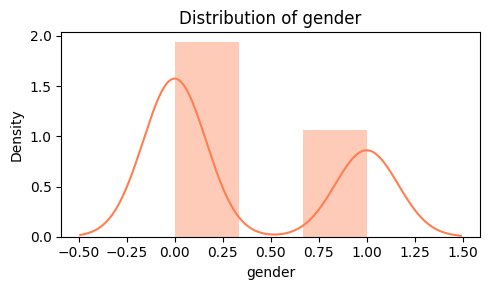

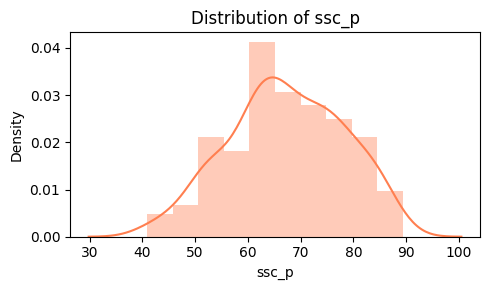

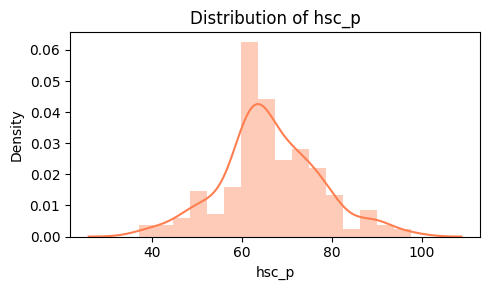

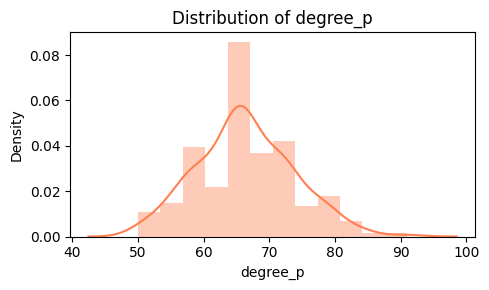

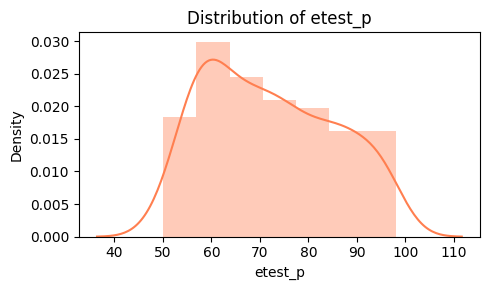

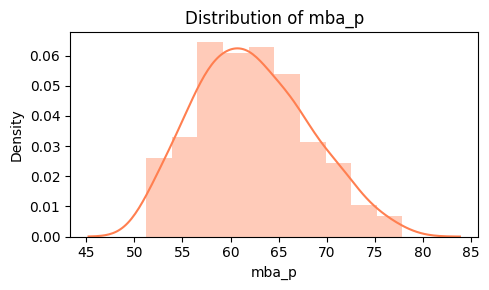

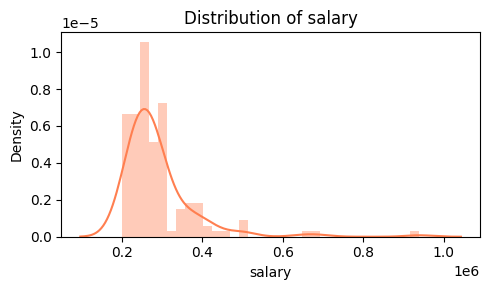

In [9]:

for col in df.columns:
    if df[col].dtype != 'object':  # Check if the column is numerical
        plt.figure(figsize=(5, 3))  # Adjust the figure size to make the plots smaller
        sns.distplot(df[col], kde=True, color='coral')  # Display density instead of count
        plt.title(f'Distribution of {col}')
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()


Most of the columns shows a bell-shaped distribution, indicating that the data is symmetrically distributed around a central value. However, the salary column stands out as it is right-skewed. This means that while most salaries are concentrated on the lower end, there are some higher salaries that pull the average up, resulting in an asymmetric distribution.

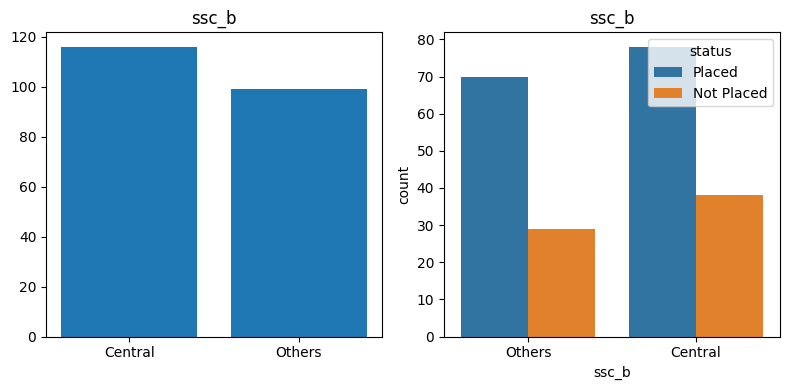

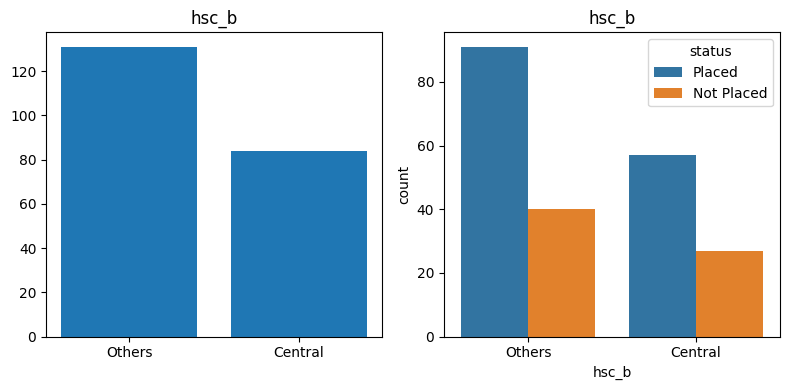

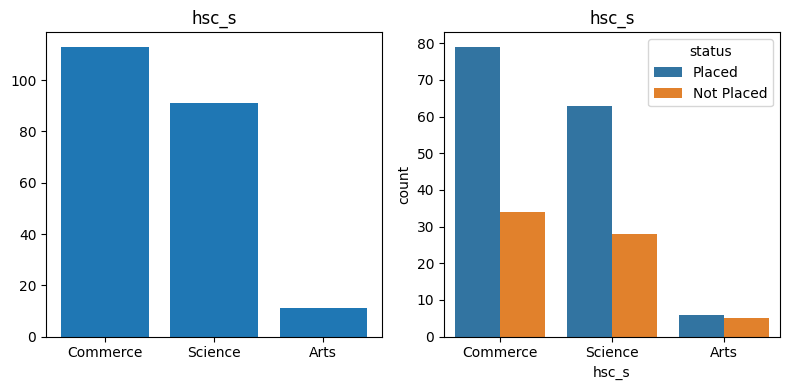

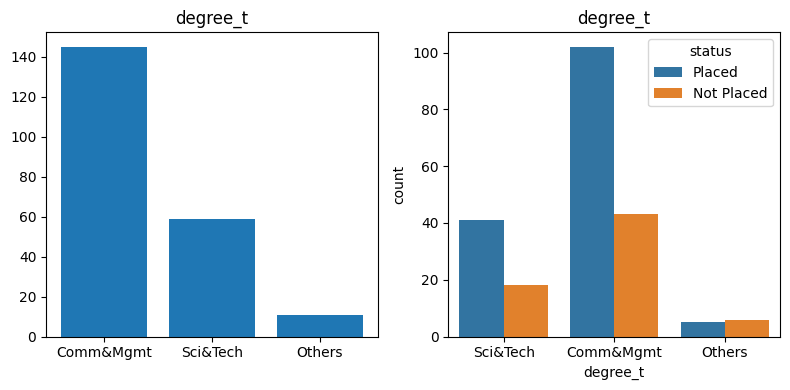

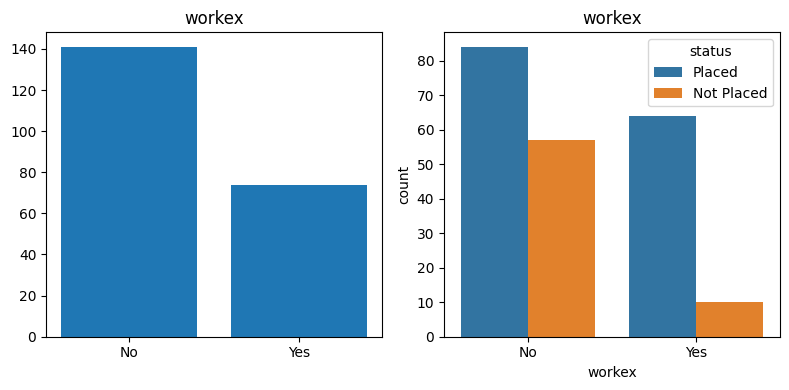

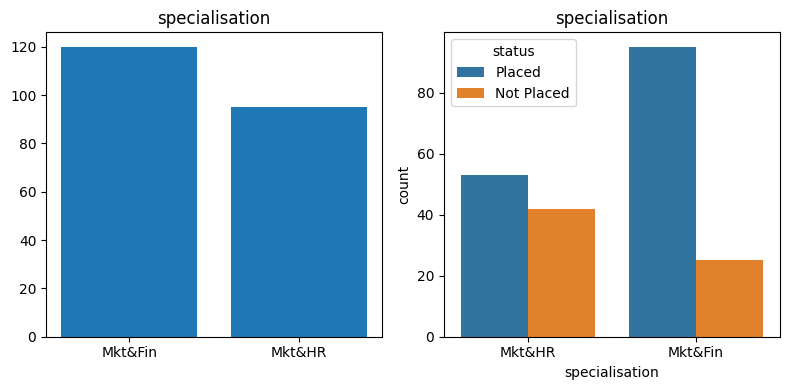

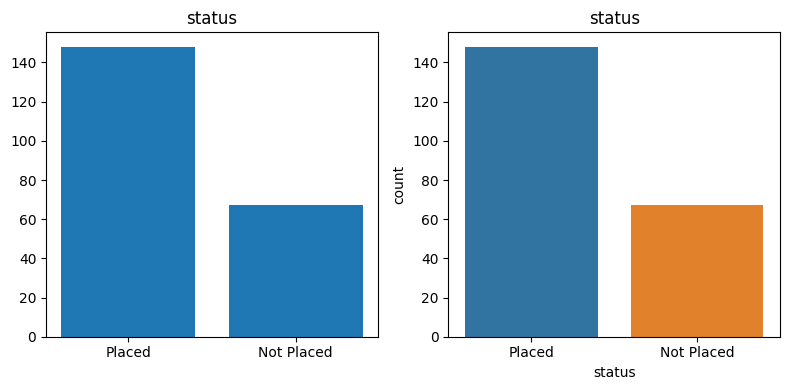

In [10]:
#Checking distribution of categorical variables
for colum in df.columns:
    if df[colum].dtype == 'object':  # Check if the column is categorical
        plt.figure(figsize=(8,4))  # Set smaller figure size for the plots
        plt.subplot(1,2,1)  # Create the first subplot in a 1x2 grid
        plt.bar(df[colum].value_counts().index, df[colum].value_counts(), label='status')  # Bar plot for value counts
        plt.title(colum)  # Title for the first subplot
        plt.subplot(1,2,2)  # Create the second subplot in a 1x2 grid
        sns.countplot(x=colum, hue='status', data=df)  # Count plot, with hue based on the 'status' column
        plt.title(colum)  # Title for the second subplot
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()  # Show the plots

The categorical variables indicate a clear trend where the ratio of placed to not placed students is typically 2:1. This means that for every 2 students who secure placement, there is 1 who does not. However, there are a few notable exceptions:

-In the specialization category, the Mkt&HR specialization has a nearly equal distribution between placed and not placed students. On the other hand, the Mkt&Fin specialization shows a ratio of about 4:1, indicating that for every 4 students placed, there is only 1 who is not.

-Interestingly, students with other degrees show a higher number of those not placed compared to those who are placed, which is unusual for this dataset. A similar situation occurs within the Arts category, where the number of placed and not placed students is about the same.

Overall, the dataset displays a significant imbalance, with many more students placed than those who are not.


**Now, I'm going to verify how many students got placed:**


In [11]:
df['status'].unique()

array(['Placed', 'Not Placed'], dtype=object)

In [12]:
df['status'].value_counts()

,count
status,
Placed,148
Not Placed,67


**Encoding**

In [13]:
{column: list(df[column].unique()) for column in df.select_dtypes('object').columns}

{'ssc_b': ['Others', 'Central'],
 'hsc_b': ['Others', 'Central'],
 'hsc_s': ['Commerce', 'Science', 'Arts'],
 'degree_t': ['Sci&Tech', 'Comm&Mgmt', 'Others'],
 'workex': ['No', 'Yes'],
 'specialisation': ['Mkt&HR', 'Mkt&Fin'],
 'status': ['Placed', 'Not Placed']}

Here are shown the values that are in each categorical column. Two columns contain three categories each, while the remaining columns have two categories. As a result, the columns with two categories will be encoded using label encoding, and those with three categories will be processed with one-hot encoding. To ensure the correct labels are assigned, I will manually encode the target variable first, following the specified order.


In [14]:
df['status'] = df['status'].map({'Placed': 1, 'Not Placed': 0})

In [15]:
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder from sklearn
label_encoder = LabelEncoder()  # Initialize the LabelEncoder instance

# Loop through each column in the DataFrame
for colum in df.columns:
    if df[colum].dtype == 'object':  # Check if the column is of object (categorical) data type
        if df[colum].nunique() == 2:  # Check if the column has exactly two unique values
            df[colum] = label_encoder.fit_transform(df[colum])  # Apply LabelEncoder to map values to 0 and 1

In [16]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,status
0,0,67.00,1,91.00,1,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,270000.0,1
1,0,79.33,0,78.33,1,Science,77.48,Sci&Tech,1,86.5,0,66.28,200000.0,1
2,0,65.00,0,68.00,0,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,250000.0,1
3,0,56.00,0,52.00,0,Science,52.00,Sci&Tech,0,66.0,1,59.43,NaN,0
4,0,85.80,0,73.60,0,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,425000.0,1


In [17]:
# Importing OneHotEncoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder with sparse_output=False to return a dense matrix
one_hot_encoder = OneHotEncoder(sparse_output=False)

# List to store the names of columns to be encoded
columns_to_encode = []

# Loop through each column in the dataframe
for column in df.columns:
    # Check if the column is categorical (object type) and has 3 unique categories
    if df[column].dtype == 'object' and df[column].nunique() == 3:
        # Append the column name to the list if it meets the condition
        columns_to_encode.append(column)

# Apply OneHotEncoding to the selected columns
encoded_data = one_hot_encoder.fit_transform(df[columns_to_encode])

# Create a new DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(columns_to_encode))

# Concatenate the encoded columns back to the original dataframe
df = pd.concat([df, encoded_df], axis=1)

In [18]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,status,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech
0,0,67.00,1,91.00,1,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,270000.0,1,0.0,1.0,0.0,0.0,0.0,1.0
1,0,79.33,0,78.33,1,Science,77.48,Sci&Tech,1,86.5,0,66.28,200000.0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,0,65.00,0,68.00,0,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,250000.0,1,1.0,0.0,0.0,1.0,0.0,0.0
3,0,56.00,0,52.00,0,Science,52.00,Sci&Tech,0,66.0,1,59.43,NaN,0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,85.80,0,73.60,0,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,425000.0,1,0.0,1.0,0.0,1.0,0.0,0.0


**Checking null values in the dataset**

In [19]:
df.isnull().sum()

,0
gender,0
ssc_p,0
ssc_b,0
hsc_p,0
hsc_b,0
hsc_s,0
degree_p,0
degree_t,0
workex,0
etest_p,0


There are 67 null values in the colum named 'salary'.

It is evident that all entries with null values in the salary column correspond to students who are not placed. Given the imbalance in the dataset, it's important to retain these records instead of discarding them. Therefore, I will use target imputation to estimate the missing salary values based on the salaries associated with the degree column.


In [20]:
print('Not placed with Null salary: ', df[(df['salary'].isnull()) & (df['status'] == 0)].shape[0])
print('Placed with Null salary: ', df[(df['salary'].isnull()) & (df['status'] == 1)].shape[0])


Not placed with Null salary:  67
Placed with Null salary:  0


In the context of this dataset, the status column typically represents the target variable indicating whether an individual has been placed. It is crucial to drop this column before splitting the dataset into training and testing sets to avoid data leakage, which occurs when information from the target variable influences the training process. This ensures that the model is trained solely on the features and can generalize to unseen data, leading to valid performance assessments. By keeping the status column separate, we maintain the integrity of the model evaluation.

In [21]:
X = df.drop('status', axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:

X_train.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech
198,1,67.0,0,70.0,0,Commerce,65.0,Others,0,88.00,1,71.96,NaN,0.0,1.0,0.0,0.0,1.0,0.0
82,0,63.0,0,67.0,0,Commerce,74.0,Comm&Mgmt,0,82.00,0,60.44,NaN,0.0,1.0,0.0,1.0,0.0,0.0
65,0,54.0,1,47.0,1,Science,57.0,Comm&Mgmt,0,89.69,1,57.10,NaN,0.0,0.0,1.0,1.0,0.0,0.0
109,0,52.0,0,63.0,1,Science,65.0,Sci&Tech,1,86.00,1,56.09,NaN,0.0,0.0,1.0,0.0,0.0,1.0
182,0,52.0,1,65.0,1,Arts,57.0,Others,1,75.00,0,59.81,NaN,1.0,0.0,0.0,0.0,1.0,0.0


In [23]:
degree_salary_means = X_train.groupby('degree_t')['salary'].mean()
degree_salary_means

,salary
degree_t,
Comm&Mgmt,284041.666667
Others,300000.000000
Sci&Tech,305793.103448


To impute missing values in the salary column based on the degree_t column, we first calculate the mean salary for each unique degree_t category in the training data. Then, we apply these mean values to fill missing salary entries in both the training and test datasets by using the degree_t value as a reference. This ensures that missing salary values are replaced consistently with the corresponding category's average, preserving the relationship between degree_t and salary without data leakage.

In [24]:
X_train.loc[(X_train['salary'].isnull()) & (X_train['degree_t'] == 'Comm&Mgmt'), 'salary'] = degree_salary_means['Comm&Mgmt']
X_train.loc[(X_train['salary'].isnull()) & (X_train['degree_t'] == 'Others'), 'salary'] = degree_salary_means['Others']
X_train.loc[(X_train['salary'].isnull()) & (X_train['degree_t'] == 'Sci&Tech'), 'salary'] = degree_salary_means['Sci&Tech']



In [25]:
X_test.loc[(X_test['salary'].isnull()) & (X_test['degree_t'] == 'Comm&Mgmt'), 'salary'] = degree_salary_means['Comm&Mgmt']
X_test.loc[(X_test['salary'].isnull()) & (X_test['degree_t'] == 'Others'), 'salary'] = degree_salary_means['Others']
X_test.loc[(X_test['salary'].isnull()) & (X_test['degree_t'] == 'Sci&Tech'), 'salary'] = degree_salary_means['Sci&Tech']

In [26]:
print('Missing values in X_train: ', X_train.isna().sum().sum())
print('Missing values in X_test: ', X_test.isna().sum().sum())


Missing values in X_train:  0
Missing values in X_test:  0


In [27]:
X_train.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,salary,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech
198,1,67.0,0,70.0,0,Commerce,65.0,Others,0,88.00,1,71.96,300000.000000,0.0,1.0,0.0,0.0,1.0,0.0
82,0,63.0,0,67.0,0,Commerce,74.0,Comm&Mgmt,0,82.00,0,60.44,284041.666667,0.0,1.0,0.0,1.0,0.0,0.0
65,0,54.0,1,47.0,1,Science,57.0,Comm&Mgmt,0,89.69,1,57.10,284041.666667,0.0,0.0,1.0,1.0,0.0,0.0
109,0,52.0,0,63.0,1,Science,65.0,Sci&Tech,1,86.00,1,56.09,305793.103448,0.0,0.0,1.0,0.0,0.0,1.0
182,0,52.0,1,65.0,1,Arts,57.0,Others,1,75.00,0,59.81,300000.000000,1.0,0.0,0.0,0.0,1.0,0.0


In [28]:
X_train.drop(columns=columns_to_encode, inplace=True)
X_test.drop(columns=columns_to_encode, inplace=True)

Implementing SMOTE (Synthetic Minority Over-sampling Technique) solely in the training dataset without missing values is essential for effectively addressing class imbalance while maintaining data integrity. By generating synthetic samples for the minority class in the training data, SMOTE helps balance class distribution, which enhances the model's ability to learn from underrepresented classes. Importantly, applying SMOTE only to the training set prevents data leakage, ensuring that the test dataset remains untouched and unbiased, allowing for a more accurate evaluation of the model's performance on unseen data. Additionally, working with a complete dataset free of missing values during this process ensures the reliability of the synthetic samples generated. Overall, this approach leads to a robust and valid model evaluation while addressing the challenges of class imbalance.

In [29]:
# Import the SMOTE (Synthetic Minority Over-sampling Technique) from imbalanced-learn library
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with a fixed random state for reproducibility of results
smote = SMOTE(random_state=42)

# Apply SMOTE to the training dataset (X_train, y_train)
# This generates synthetic samples for the minority class to balance the class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train_resampled now contains the balanced feature set, and y_train_resampled contains the corresponding balanced target labels

In [30]:

# Import the StandardScaler from scikit-learn
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler to scale the features
std_sc = StandardScaler()

# Fit the StandardScaler to the resampled training data (X_train_resampled) and transform it
# This scales the data so that each feature has zero mean and unit variance
X_train_std_sc = std_sc.fit_transform(X_train_resampled)

# Apply the same scaling to the test data (X_test)
# Note that we only use the 'transform' method here to ensure that the test data is scaled
# based on the statistics (mean and standard deviation) of the training data
X_test_std_sc = std_sc.transform(X_test)

In [31]:

y_train_resampled.value_counts()

,count
status,
0,104
1,104


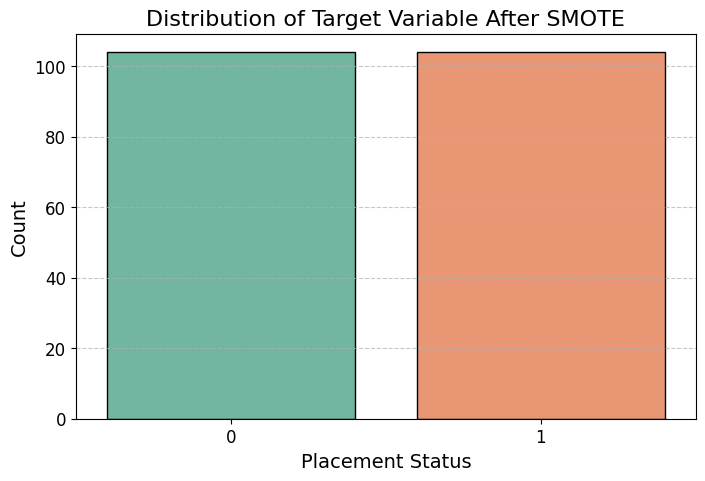

In [32]:
# Plot distribution of target variable after SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette='Set2', edgecolor='black', dodge=False, legend=False)
plt.title("Distribution of Target Variable After SMOTE", fontsize=16)
plt.xlabel("Placement Status", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Model Selection**

For a binary classification task, especially with imbalanced data, the best three models to test would be:

**1. Random Forest Classifier:**

In [33]:
# Define the parameter grid for Random Forest hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 500],        # Number of trees in the forest
    'max_depth': [None, 10, 20],             # Maximum depth of each tree
    'max_features': ['sqrt', 'log2', None]   # Number of features to consider at each split
}

# Perform GridSearchCV to find the best Random Forest model
rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_gs.fit(X_train_std_sc, y_train_resampled)



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

In [34]:
# Get the best model and its parameters
best_rf_model = rf_gs.best_estimator_
print(f"Best Parameters: {rf_gs.best_params_}")
print(f"Best F1 Score: {rf_gs.best_score_}")
print(f"Best Estimator: {rf_gs.best_estimator_}")

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
Best F1 Score: 0.9584337233376667
Best Estimator: RandomForestClassifier(n_estimators=500, random_state=42)


In [63]:
# Make predictions on test data using the best model
rf_predictions = best_rf_model.predict(X_test_std_sc)


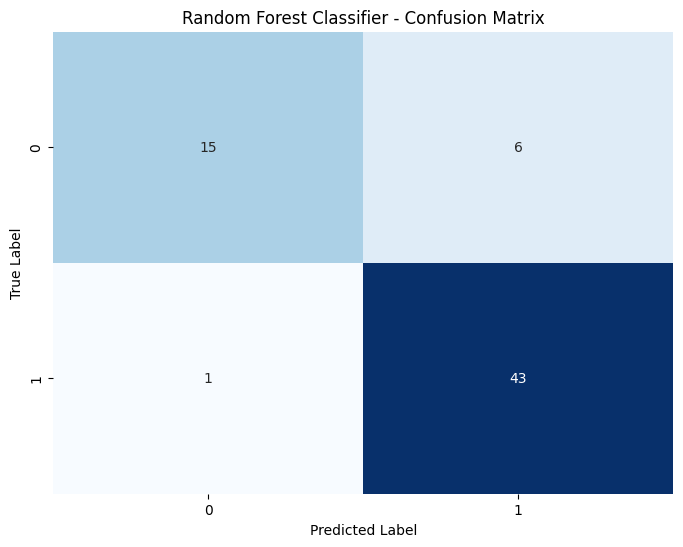

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        21
           1       0.88      0.98      0.92        44

    accuracy                           0.89        65
   macro avg       0.91      0.85      0.87        65
weighted avg       0.90      0.89      0.89        65



In [64]:
# 3. Confusion Matrix for test data
rf_cm = confusion_matrix(y_test, rf_predictions)

# Plotting confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Classifier - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report for test data
rf_class_report = classification_report(y_test, rf_predictions)
print('Classification Report (Test Data):')
print(rf_class_report)


In [65]:
# Performance Metrics for Training Data (on resampled data)
train_metrics_rf = {
    'Precision': precision_score(y_train_resampled, best_rf_model.predict(X_train_std_sc)),
    'Recall': recall_score(y_train_resampled, best_rf_model.predict(X_train_std_sc)),
    'F1 Score': f1_score(y_train_resampled, best_rf_model.predict(X_train_std_sc)),
    'Accuracy': accuracy_score(y_train_resampled, best_rf_model.predict(X_train_std_sc))
}
print("\nTraining Metrics:")
for metric, value in train_metrics_rf.items():
    print(f"{metric}: {value:.4f}")


Training Metrics:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000


In [66]:
# Performance Metrics for Test Data
test_metrics_rf = {
    'Precision': precision_score(y_test, rf_predictions),
    'Recall': recall_score(y_test, rf_predictions),
    'F1 Score': f1_score(y_test, rf_predictions),
    'Accuracy': accuracy_score(y_test, rf_predictions)
}

print("\nTesting Metrics:")
for metric, value in test_metrics_rf.items():
    print(f"{metric}: {value:.4f}")


Testing Metrics:
Precision: 0.8776
Recall: 0.9773
F1 Score: 0.9247
Accuracy: 0.8923


**2. XGBoost (Gradient Boosting)**

In [39]:
# Define the hyperparameter grid for XGBoost and run GridSearchCV
xgb_grid = {
    'n_estimators': [100, 200, 300],     # Number of boosting rounds
    'max_depth': [3, 5, 7],              # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],   # Step size shrinkage to prevent overfitting
    'subsample': [0.8, 1.0]              # Fraction of samples to use for each boosting round
}

# Perform GridSearchCV to find the best model using F1 score
xgb_search = GridSearchCV(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                          param_grid=xgb_grid,
                          cv=5,
                          scoring='f1')

In [44]:
# Fit the model with training data
xgb_search.fit(X_train_std_sc, y_train_resampled)

# Extract the best XGBoost model
best_xgb_model = xgb_search.best_estimator_

# Make predictions on test data using the best model
xgb_predictions = best_xgb_model.predict(X_test_std_sc)


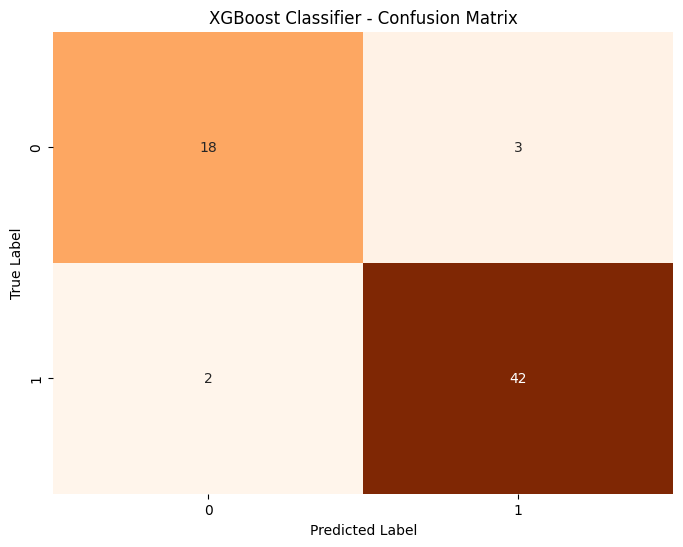

In [45]:
# Confusion Matrix for test data
xgb_cm = confusion_matrix(y_test, xgb_predictions)

# Plotting confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('XGBoost Classifier - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [52]:
# Classification report for test data
xgb_class_report = classification_report(y_test, xgb_predictions)
print('Classification Report (Test Data):')
print(xgb_class_report)


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.93      0.95      0.94        44

    accuracy                           0.92        65
   macro avg       0.92      0.91      0.91        65
weighted avg       0.92      0.92      0.92        65



In [53]:
# Performance Metrics for Training Data (on resampled data)
train_metrics_xgb = {
    'Precision': precision_score(y_train_resampled, best_xgb_model.predict(X_train_std_sc)),
    'Recall': recall_score(y_train_resampled, best_xgb_model.predict(X_train_std_sc)),
    'F1 Score': f1_score(y_train_resampled, best_xgb_model.predict(X_train_std_sc)),
    'Accuracy': accuracy_score(y_train_resampled, best_xgb_model.predict(X_train_std_sc))
}

print("\nTraining Metrics:")
for metric, value in train_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")


Training Metrics:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000


In [51]:
# Performance Metrics for Test Data
test_metrics_xgb = {
    'Precision': precision_score(y_test, xgb_predictions),
    'Recall': recall_score(y_test, xgb_predictions),
    'F1 Score': f1_score(y_test, xgb_predictions),
    'Accuracy': accuracy_score(y_test, xgb_predictions)
}
print("\nTesting Metrics:")
for metric, value in test_metrics_xgb.items():
    print(f"{metric}: {value:.4f}")


Testing Metrics:
Precision: 0.9333
Recall: 0.9545
F1 Score: 0.9438
Accuracy: 0.9231


**3. Logistic Regression**

In [54]:
 # Define the hyperparameter grid for Logistic Regression and run GridSearchCV
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2'],             # Regularization term (l2 is common for Logistic Regression)
    'solver': ['lbfgs', 'liblinear']  # Solver for optimization
}

# Perform GridSearchCV to find the best Logistic Regression model using F1 score
logreg_search = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=1000),
                             param_grid=logreg_param_grid,
                             cv=5,
                             scoring='f1')

# Fit the model with training data
logreg_search.fit(X_train_std_sc, y_train_resampled)

# Extract the best Logistic Regression model
best_logreg_model = logreg_search.best_estimator_

In [55]:
# Make predictions on test data using the best model
logreg_predictions = best_logreg_model.predict(X_test_std_sc)

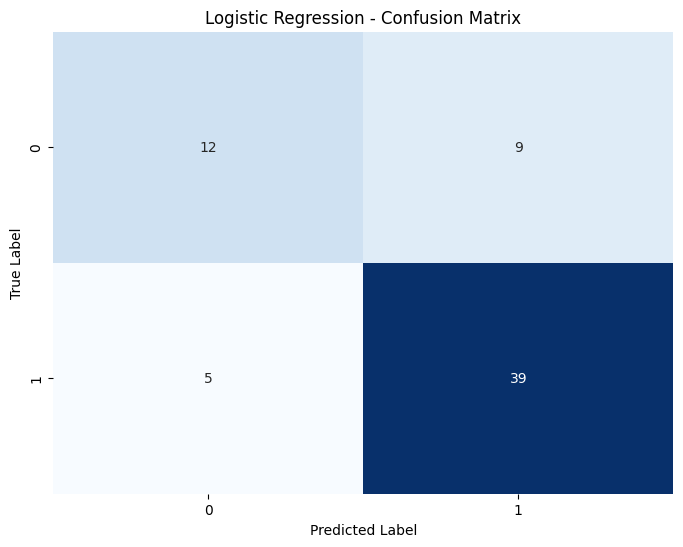

In [57]:
# Confusion Matrix for test data
logreg_cm = confusion_matrix(y_test, logreg_predictions)
# Plotting confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [58]:
# Classification report for test data
logreg_class_report = classification_report(y_test, logreg_predictions)
print('Classification Report (Test Data):')
print(logreg_class_report)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.71      0.57      0.63        21
           1       0.81      0.89      0.85        44

    accuracy                           0.78        65
   macro avg       0.76      0.73      0.74        65
weighted avg       0.78      0.78      0.78        65



In [59]:
# Performance Metrics for Training Data (on resampled data)
train_metrics_logreg = {
    'Precision': precision_score(y_train_resampled, best_logreg_model.predict(X_train_std_sc)),
    'Recall': recall_score(y_train_resampled, best_logreg_model.predict(X_train_std_sc)),
    'F1 Score': f1_score(y_train_resampled, best_logreg_model.predict(X_train_std_sc)),
    'Accuracy': accuracy_score(y_train_resampled, best_logreg_model.predict(X_train_std_sc))
}
print("\nTraining Metrics:")
for metric, value in train_metrics_logreg.items():
    print(f"{metric}: {value:.4f}")


Training Metrics:
Precision: 0.9151
Recall: 0.9327
F1 Score: 0.9238
Accuracy: 0.9231


In [60]:
# Performance Metrics for Test Data
test_metrics_logreg = {
    'Precision': precision_score(y_test, logreg_predictions),
    'Recall': recall_score(y_test, logreg_predictions),
    'F1 Score': f1_score(y_test, logreg_predictions),
    'Accuracy': accuracy_score(y_test, logreg_predictions)
}
print("\nTesting Metrics:")
for metric, value in test_metrics_logreg.items():
    print(f"{metric}: {value:.4f}")



Testing Metrics:
Precision: 0.8125
Recall: 0.8864
F1 Score: 0.8478
Accuracy: 0.7846


**Voting Classifier**

In [79]:
# Initialize the base classifiers with new names
log_reg = LogisticRegression(C=1, penalty='l2', random_state=42)  # Logistic Regression
svm_clf = SVC(C=10, degree=2, kernel='linear', random_state=42)  # Support Vector Classifier
rf_clf = RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=500, random_state=42)  # Random Forest
xgboost_clf = XGBClassifier(learning_rate=0.01, max_depth=6, n_estimators=500, random_state=42)  # XGBoost

# Initialize the Voting Classifier with the above base models
voting_classifier = VotingClassifier(estimators=[('log_reg', log_reg), ('svm_clf', svm_clf), ('rf_clf', rf_clf), ('xgboost_clf', xgboost_clf)], voting='hard')

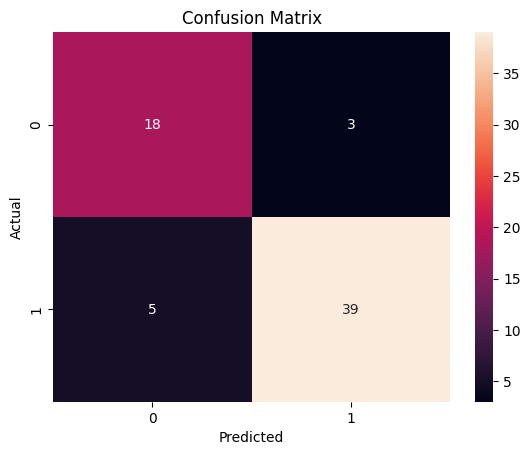

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.93      0.89      0.91        44

    accuracy                           0.88        65
   macro avg       0.86      0.87      0.86        65
weighted avg       0.88      0.88      0.88        65



In [81]:

# Fit the Voting Classifier on the resampled training data
voting_classifier.fit(X_train_std_sc, y_train_resampled)

# Make predictions on the test set
y_pred_voting = voting_classifier.predict(X_test_std_sc)  # Corrected variable name

# Generate and plot the confusion matrix
cm_voting = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm_voting, annot=True, fmt='d')  # annot=True to show the values in the heatmap
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report to evaluate the model's performance
print(classification_report(y_test, y_pred_voting))

In [84]:
# Calculate performance metrics for the testing set
voting_precision = precision_score(y_test, y_pred_voting)
voting_recall = recall_score(y_test, y_pred_voting)
voting_f1 = f1_score(y_test, y_pred_voting)
voting_accuracy = accuracy_score(y_test, y_pred_voting)

# Display testing metrics
print('Testing metrics:')
print('Precision: ', voting_precision)
print('Recall: ', voting_recall)
print('F1 Score: ', voting_f1)
print('Accuracy: ', voting_accuracy)

Testing metrics:
Precision:  0.9285714285714286
Recall:  0.8863636363636364
F1 Score:  0.9069767441860465
Accuracy:  0.8769230769230769


In [85]:
# Print the training metrics (on resampled data)
train_precision = precision_score(y_train_resampled, voting_classifier.predict(X_train_std_sc))
train_recall = recall_score(y_train_resampled, voting_classifier.predict(X_train_std_sc))
train_f1 = f1_score(y_train_resampled, voting_classifier.predict(X_train_std_sc))
train_accuracy = accuracy_score(y_train_resampled, voting_classifier.predict(X_train_std_sc))

# Display training metrics
print('Training metrics:')
print('Precision: ', train_precision)
print('Recall: ', train_recall)
print('F1 Score: ', train_f1)
print('Accuracy: ', train_accuracy)
print('_' * 50)

Training metrics:
Precision:  1.0
Recall:  0.9519230769230769
F1 Score:  0.9753694581280788
Accuracy:  0.9759615384615384
__________________________________________________


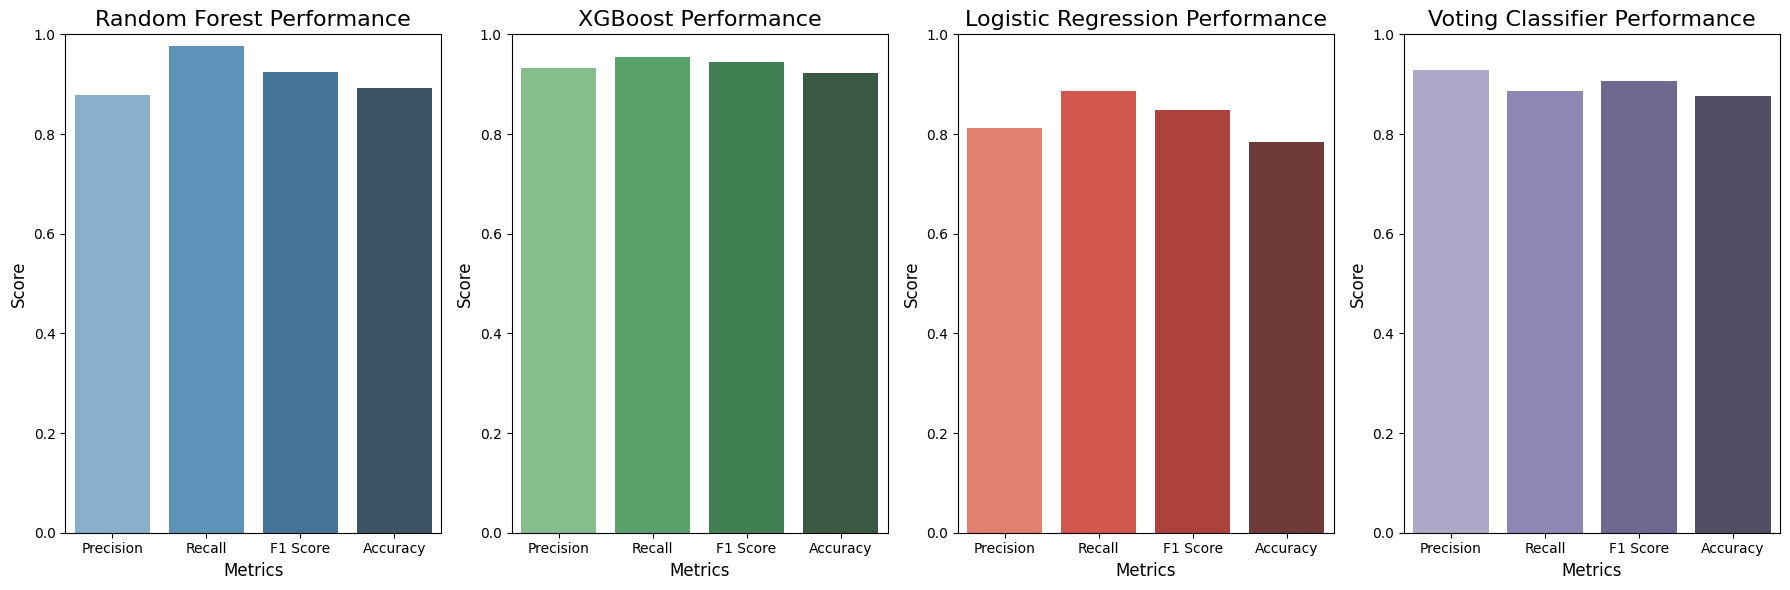

In [87]:

# Prepare the data for each model
metrics_data_rf = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [test_metrics_rf['Precision'], test_metrics_rf['Recall'], test_metrics_rf['F1 Score'], test_metrics_rf['Accuracy']]
}

metrics_data_xgb = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [test_metrics_xgb['Precision'], test_metrics_xgb['Recall'], test_metrics_xgb['F1 Score'], test_metrics_xgb['Accuracy']]
}

metrics_data_logreg = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [test_metrics_logreg['Precision'], test_metrics_logreg['Recall'], test_metrics_logreg['F1 Score'], test_metrics_logreg['Accuracy']]
}

metrics_data_voting = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [voting_precision, voting_recall, voting_f1, voting_accuracy]
}

# Convert to DataFrame for each model
df_rf = pd.DataFrame(metrics_data_rf)
df_xgb = pd.DataFrame(metrics_data_xgb)
df_logreg = pd.DataFrame(metrics_data_logreg)
df_voting = pd.DataFrame(metrics_data_voting)

# Plotting histograms
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # One row, three columns for the three models

# Random Forest Histogram
sns.barplot(x='Metric', y='Score', data=df_rf, ax=axes[0], palette='Blues_d')
axes[0].set_title("Random Forest Performance", fontsize=16)
axes[0].set_xlabel("Metrics", fontsize=12)
axes[0].set_ylabel("Score", fontsize=12)
axes[0].set_ylim(0, 1)  # Ensure consistent scale for all models

# XGBoost Histogram
sns.barplot(x='Metric', y='Score', data=df_xgb, ax=axes[1], palette='Greens_d')
axes[1].set_title("XGBoost Performance", fontsize=16)
axes[1].set_xlabel("Metrics", fontsize=12)
axes[1].set_ylabel("Score", fontsize=12)
axes[1].set_ylim(0, 1)  # Ensure consistent scale for all models

# Logistic Regression Histogram
sns.barplot(x='Metric', y='Score', data=df_logreg, ax=axes[2], palette='Reds_d')
axes[2].set_title("Logistic Regression Performance", fontsize=16)
axes[2].set_xlabel("Metrics", fontsize=12)
axes[2].set_ylabel("Score", fontsize=12)
axes[2].set_ylim(0, 1)  # Ensure consistent scale for all models

# Voting Classifier Histogram
sns.barplot(x='Metric', y='Score', data=df_voting, ax=axes[3], palette='Purples_d')
axes[3].set_title("Voting Classifier Performance", fontsize=16)
axes[3].set_xlabel("Metrics", fontsize=12)
axes[3].set_ylabel("Score", fontsize=12)
axes[3].set_ylim(0, 1)  # Ensure consistent scale for all models

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


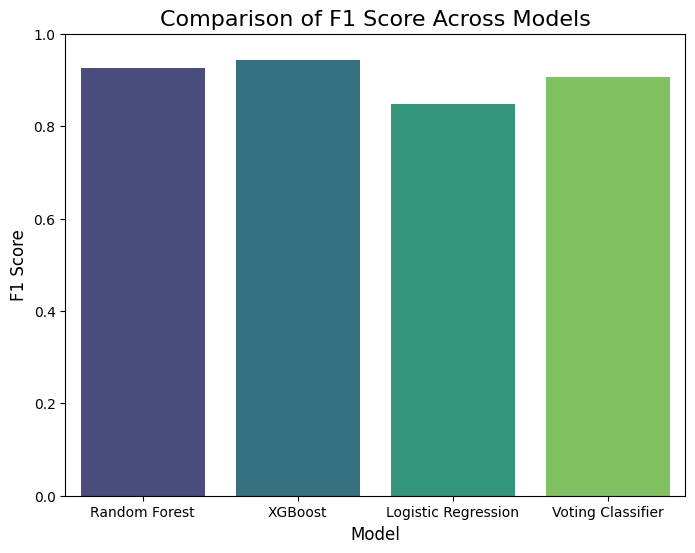

In [90]:

# F1 Scores for each model (using the F1 Scores from the previous model evaluation)
f1_scores = {
    'Random Forest': test_metrics_rf['F1 Score'],
    'XGBoost': test_metrics_xgb['F1 Score'],
    'Logistic Regression': test_metrics_logreg['F1 Score'],
    'Voting Classifier': voting_f1
}

# Convert to DataFrame for easy plotting
df_f1 = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score'])

# Plotting the F1 Score comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='F1 Score', data=df_f1, palette='viridis')

# Customize the plot
plt.title('Comparison of F1 Score Across Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1)  # Ensuring consistent scale (0 to 1)
plt.show()
